In [2]:
import numpy as np
import matplotlib.pyplot as plt
from math import pi
plt.rcParams['image.cmap'] = 'jet'
plt.rcParams['figure.facecolor'] = 'white'

In [3]:
def phi_anisotropic(kx, ky, F4, l):
    k = np.sqrt(kx * kx + ky * ky)
    return k * np.exp(-kx*kx / F4) / ((kx + l*1.0j) * (kx + l*1.0j) - k)

def calculate_wake(F, l=0.01, kmax=128, d=0.125):
    k = np.arange(-kmax, kmax+d, d)
    n = len(k)
    
    m = (n - 1) / 2
    x = pi / (d * m) * np.arange(-m, m+1, 1)
    
    phi_induced = phi_anisotropic(k[:, None], k[None, :], \
                                  np.power(F, 4.0), l)
    
    #Rotate grid since dft starts at zero
    phi_grid = np.roll(phi_induced, -m, axis=0)
    phi_grid = np.roll(phi_grid, -m, axis=1)
    
    fPhi = d*d * np.fft.ifft2(phi_grid)
    fPhi = np.roll(fPhi, m, axis=1)
    fPhi = np.roll(fPhi, m, axis=0)
    fPhi = np.transpose(fPhi)
    
    return x, fPhi

In [1]:
phase = -1.7

def draw_wake_plot(ax, x, phi, bound=None, scale=False):
    r = x[-1]
    stdev = np.std(phi)
    if bound is not None:
        avg = np.average(phi)
        ubound = avg + bound * stdev
        lbound = avg - bound * stdev
        toshow = phi * (phi < ubound) * (phi > lbound)
        toshow[phi > ubound] = ubound
        toshow[phi < lbound] = lbound
    else:
        toshow = phi
        avg = np.average(phi)
        ubound = np.max(toshow[:])
        lbound = np.min(toshow[:])
    if scale:
        toshow -= avg
        toshow = toshow / (ubound - lbound) * 2
        img = plt.imshow(toshow, extent=[-r, r, -r, r], \
                         interpolation='gaussian',
                         vmin=-1, vmax=1)
    else:
        ubound = np.max(toshow[:])
        lbound = np.min(toshow[:])
        rnge = ubound - lbound
        toshow = toshow - lbound - rnge/2
        toshow = toshow / rnge * 2
        img = plt.imshow(toshow, extent=[-r, r, -r, r], \
                         interpolation='gaussian')
    return img

def draw_kelvin_angle(ax, x, f=1000, color='blue'):
    y = np.sqrt(x**2.0/8.)
    ax.plot(x, y, color=color, linestyle=':')

def draw_inner_angle(ax, x, T, color='black'):
    slope = np.sqrt(T - 1.) / (2. * T - 1.)
    y = slope * x
    ax.plot(x, -y, color=color, linestyle=':')
    
def draw_parametric_wake(ax, nmax, t, color='black', phase=phase):
    t32 = np.power(t, 1.5)
    xtterm = (2*t - 1) / t32
    ytterm = np.sqrt(t - 1) / t32
    for n in range(1, nmax+1):
        t32 = np.power(t, 1.5)
        xt = -np.pi * (2 * n + 1 + phase) * xtterm
        yt = -np.pi * (2 * n + 1 + phase) * ytterm
        ax.plot(xt, -yt, color=color, linestyle=':', linewidth=1)

def draw_slope_xint(ax, slope, xint, x0, color='black', full=False):
    x = np.array([x0, xint])
    y = slope * (x - xint)
    ax.plot(x, y, color=color, linestyle=':', linewidth=1)
    if full:
        ax.plot(x, -y, color=color, linestyle=':', linewidth=1)

def calc_T_value(f, a=1):
    return a * f * f * f * f

In [2]:
def create_large_figure(fig, xvals, phis, froudes, nrows, ncols, bounds=None, scale=False,
                        kelvin=False, inner=False, parametric=False, xshift=0, xfull=False,
                        xbounds=None, ybounds=None, slopes=None, xints=None, a=1):
    if xbounds is None and ybounds is None:
        try:
            xbounds = [xvals[0, 0], xvals[0, -1] if xfull else 0]
            ybounds = [xvals[0, 0]/2, xvals[0, -1]/2]
        except:
            xbounds = [xvals[0][0], xvals[0][-1] if xfull else 0]
            ybounds = [xvals[0][0]/2, xvals[0][-1]/2]
        xbounds = xbounds - xbounds[0] * xshift
    label = 'a'
    
    for r in range(nrows):
        for c in range(ncols):
            i = r * ncols + c
            ax = fig.add_subplot(nrows, ncols, i+1)
            ax.set_xlim(xbounds)
            ax.set_ylim(ybounds)
            ax.text(0.97, 0.97, 'F=%.2f' % froudes[i], 
                    transform=ax.transAxes,
                    horizontalalignment='right',
                    verticalalignment='top')
            ax.text(0.97, 0.03, label, 
                    transform=ax.transAxes,
                    horizontalalignment='right',
                    verticalalignment='bottom')
            label = chr(ord(label) + 1)
            if bounds is None:
                bound = None
            elif type(bounds) == list:
                bound = bounds[i]
            else:
                bound = bounds
            
            img = draw_wake_plot(ax, xvals[i], phis[i], bound=bound, scale=scale)

            if slopes is not None and xints is not None:
                draw_slope_xint(ax, slopes[i], xints[i], xbounds[0], full=True)
                if kelvin:
                    draw_slope_xint(ax, -1./np.sqrt(8), xints[i], xbounds[0])
            else:
                xs = xvals[i][xvals[i] <= 0]
                if kelvin:                    
                    draw_kelvin_angle(ax, xs)
                if inner:
                    draw_inner_angle(ax, xs, calc_T_value(froudes[i], a=a), color='black')
                if parametric:
                    t = np.linspace(1, calc_T_value(froudes[i], a=a), 10000)
                    draw_parametric_wake(ax, 4, t, color='black')
            if c == 0:
                ax.set_ylabel('Y')
            else:
                nlbls = len(ax.get_yticklabels())
                ax.set_yticklabels([''] * nlbls)
            if r == nrows - 1:
                ax.set_xlabel('X')
            else:
                nlbls = len(ax.get_xticklabels())
                ax.set_xticklabels([''] * nlbls)

In [40]:
vsmFs = [0.6, 0.65, 0.7, 0.75, 0.8]
tr1Fs = [0.66, 0.68, 0.7, 0.72, 0.74]
tr2Fs = [0.76, 0.78, 0.8, 0.82, 0.84]
tr3Fs = [0.83, 0.86, 0.89, 0.92, 0.95]
tr4Fs = [0.85, 0.87, 0.89, 0.91, 0.93]
smlFs = [0.86, 0.9, 0.94, 0.98, 1.0]
medFs = [1.02, 1.06, 1.1, 1.15, 1.2]
morFs = [1.5, 1.75, 2.0, 2.5, 3.0]
remFs = [0.96, 1.4, 1.6, 1.8]

vsmKmax = 128
smlKmax = 128
medKmax = 128
morKmax = 256
delta = 1. / 8.

def generate_wake_patterns(fvals, kmax, delta):
    xs = []
    phis = []
    for f in fvals:
        x, p = calculate_wake(f, kmax=kmax, d=delta)
        xs.append(np.real(x))
        phis.append(np.real(p))
        print('F = %f done' % f)
    
    return xs, phis

In [9]:
vsmXs, vsmPs = generate_wake_patterns(vsmFs, vsmKmax, delta)

F = 0.600000 done
F = 0.650000 done
F = 0.700000 done
F = 0.750000 done
F = 0.800000 done


In [10]:
tr1Xs, tr1Ps = generate_wake_patterns(tr1Fs, vsmKmax, delta)

F = 0.660000 done
F = 0.680000 done
F = 0.700000 done
F = 0.720000 done
F = 0.740000 done


In [11]:
tr2Xs, tr2Ps = generate_wake_patterns(tr2Fs, vsmKmax, delta)

F = 0.760000 done
F = 0.780000 done
F = 0.800000 done
F = 0.820000 done
F = 0.840000 done


In [12]:
tr3Xs, tr3Ps = generate_wake_patterns(tr3Fs, vsmKmax, delta)

F = 0.830000 done
F = 0.860000 done
F = 0.890000 done
F = 0.920000 done
F = 0.950000 done


In [13]:
tr4Xs, tr4Ps = generate_wake_patterns(tr4Fs, vsmKmax, delta)

F = 0.850000 done
F = 0.870000 done
F = 0.890000 done
F = 0.910000 done
F = 0.930000 done


In [14]:
smlXs, smlPs = generate_wake_patterns(smlFs, smlKmax, delta)

F = 0.860000 done
F = 0.900000 done
F = 0.940000 done
F = 0.980000 done
F = 1.000000 done


In [15]:
medXs, medPs = generate_wake_patterns(medFs, medKmax, delta)

F = 1.020000 done
F = 1.060000 done
F = 1.100000 done
F = 1.150000 done
F = 1.200000 done


In [38]:
morXs, morPs = generate_wake_patterns(morFs, morKmax, delta)

F = 1.500000 done
F = 1.750000 done
F = 2.000000 done
F = 2.500000 done
F = 3.000000 done


In [41]:
remXs, remPs = generate_wake_patterns(remFs, morKmax, delta)

F = 0.960000 done
F = 1.400000 done
F = 1.600000 done
F = 1.800000 done


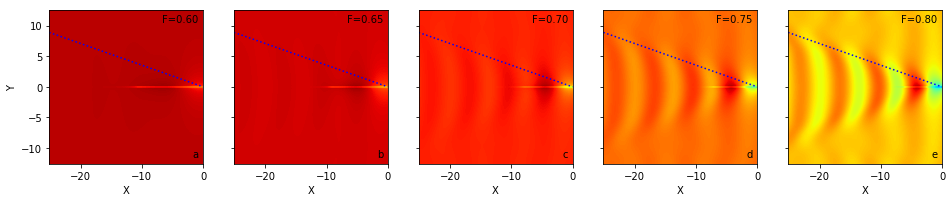

In [17]:
fig = plt.figure(figsize=(16, 8))
create_large_figure(fig, vsmXs, vsmPs, vsmFs,
                    1, 5, scale=False, bounds=3,
                    kelvin=True, inner=False, parametric=False)

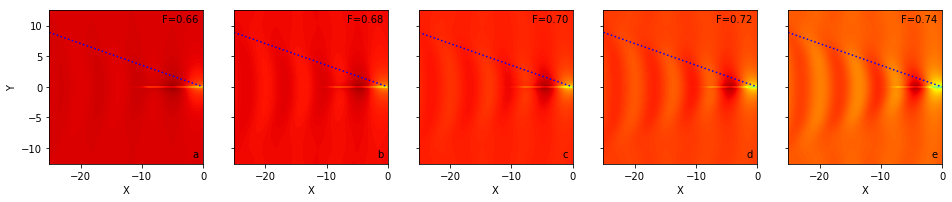

In [18]:
fig = plt.figure(figsize=(16, 8))
create_large_figure(fig, tr1Xs, tr1Ps, tr1Fs,
                    #1, 5, scale=False,
                    1, 5, scale=False, bounds=3,
                    kelvin=True, inner=False, parametric=False)

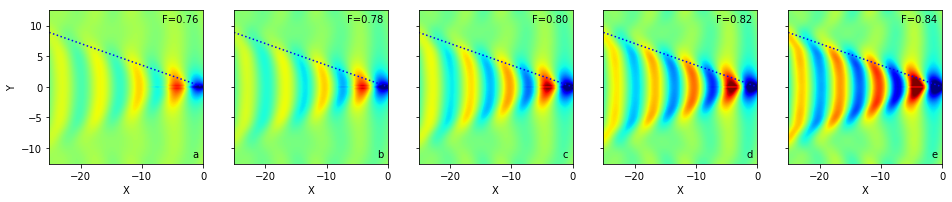

In [28]:
fig = plt.figure(figsize=(16, 8))
create_large_figure(fig, tr2Xs, tr2Ps, tr2Fs,
                    1, 5, scale=False, bounds=1,
                    kelvin=True, inner=False, parametric=False)

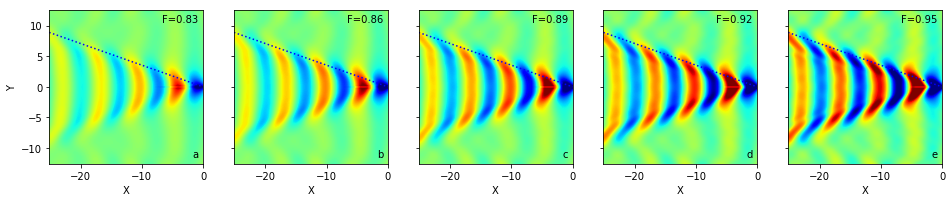

In [30]:
fig = plt.figure(figsize=(16, 8))
create_large_figure(fig, tr3Xs, tr3Ps, tr3Fs,
                    1, 5, 
                    #scale=False,
                    scale=True, bounds=1.5,
                    kelvin=True, inner=False, parametric=False, a=2)

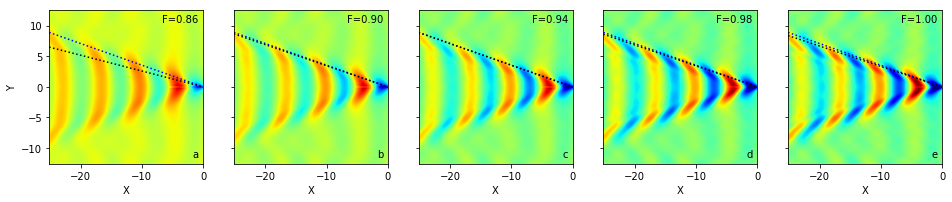

In [25]:
fig = plt.figure(figsize=(16, 8))
create_large_figure(fig, smlXs, smlPs, smlFs,
                    #1, 5, scale=False,
                    1, 5, scale=False, bounds=3,
                    kelvin=True, inner=True, parametric=False, a=2)

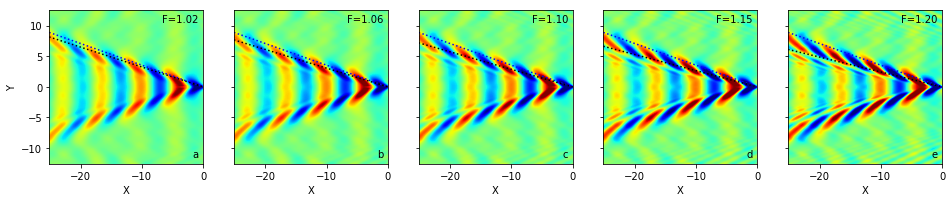

In [26]:
fig = plt.figure(figsize=(16, 8))
create_large_figure(fig, medXs, medPs, medFs,
                    #1, 5, scale=False,
                    1, 5, scale=True, bounds=3,
                    kelvin=True, inner=True, parametric=False, a=2)

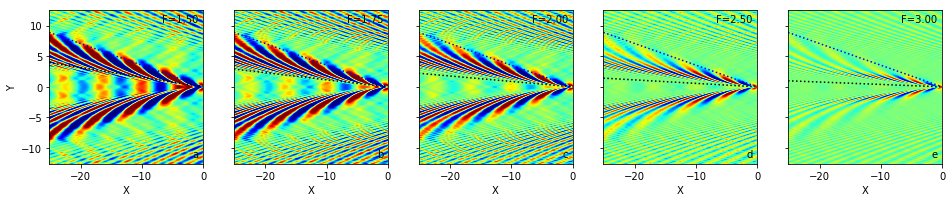

In [23]:
fig = plt.figure(figsize=(16, 8))
create_large_figure(fig, morXs, morPs, morFs,
                    1, 5, scale=True, bounds=[1.5, 1.5, 1.5, 1.5, 1.5],
                    #1, 5, scale=False,
                    kelvin=True, inner=True, parametric=False, a=2)

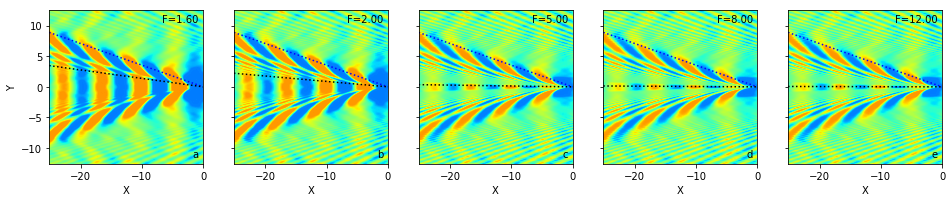

In [63]:
fig = plt.figure(figsize=(16, 8))
create_large_figure(fig, lrgXs, lrgPs, lrgFs,
                    1, 5, scale=False, bounds=[1.5, 1.5, 1.25, 1.25, 1.25],
                    kelvin=True, inner=True, parametric=False, a=2)

F = 0.760, T = 1.034
F = 0.780, T = 1.147
F = 0.800, T = 1.270
F = 0.820, T = 1.402
F = 0.840, T = 1.543
F = 0.900, T = 2.034
F = 0.920, T = 2.221
F = 0.940, T = 2.420
F = 0.960, T = 2.633
F = 0.980, T = 2.859
F = 1.000, T = 3.100
F = 1.200, T = 6.428
F = 1.400, T = 11.909
F = 1.600, T = 20.316
F = 1.800, T = 32.543


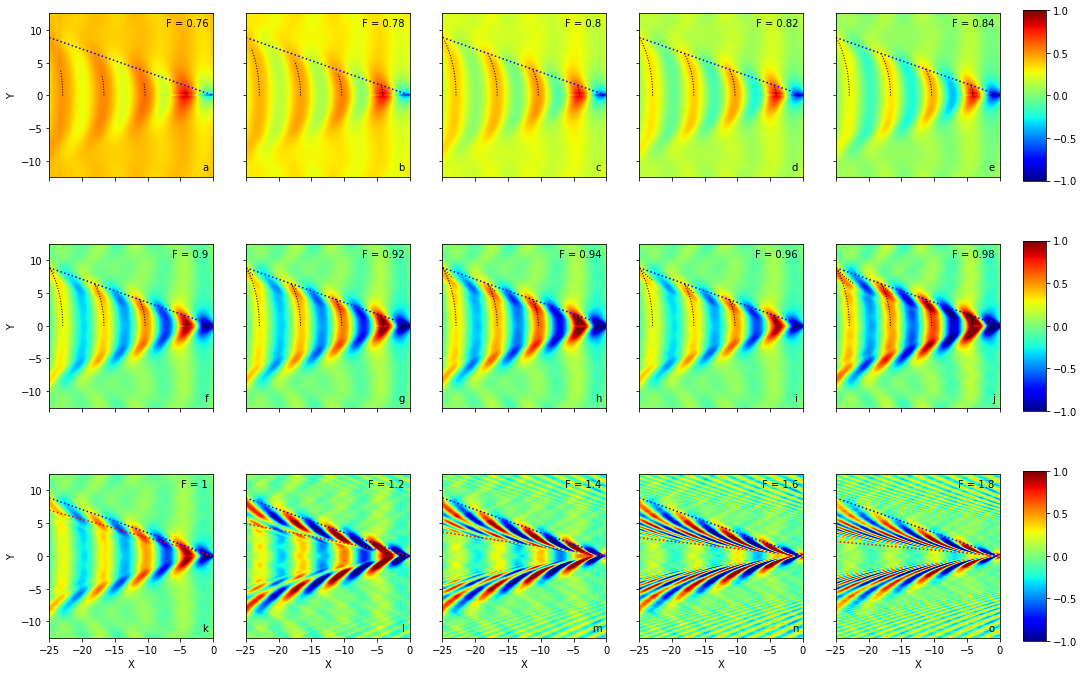

In [45]:
rows = np.array([[0.66, 0.7, 0.74, 0.78, 0.82],
                 [0.85, 0.87, 0.89, 0.91, 0.93],
                 [1.0, 1.2, 1.5, 2.0, 2.5]])
                 #[1.0, 1.2, 1.5, 2.0, 3.0]])
bounds = np.array([[2, 2, 2, 2, 2],
                   [2, 2, 2, 2, 2],
                   #[2, 2, 1.5, 0.75, 0.25]])
                   [3, 3, 3, 2, 0.75]])

rows = np.array([[0.76, 0.78, 0.8, 0.82, 0.84],
                 [0.9, 0.92, 0.94, 0.96, 0.98],
                 [1, 1.2, 1.4, 1.6, 1.8]])
bounds = np.array([[2, 2, 2, 2, 2],
                   [2, 2, 2, 2, 2],
                   [3, 3, 3, 3, 3]])

scales = [False, False, True]

xbounds = [-25, 0]
ybounds = [-12.5, 12.5]
npy, npx = rows.shape
    
fig = plt.figure(figsize=(16, 12))
axs, imgs = [None, None, None], [None, None, None]
label = 'a'

a = 3.1

for j in range(npy):
    for i in range(npx):
        ax = fig.add_subplot(npy, npx, j*npx + i + 1)
        fr = rows[j, i]
        if fr in tr1Fs:
            ind = tr1Fs.index(fr)
            xv, pv = tr1Xs[ind], tr1Ps[ind]
        elif fr in tr2Fs:
            ind = tr2Fs.index(fr)
            xv, pv = tr2Xs[ind], tr2Ps[ind]
        elif fr in tr3Fs:
            ind = tr3Fs.index(fr)
            xv, pv = tr3Xs[ind], tr3Ps[ind]
        elif fr in tr4Fs:
            ind = tr4Fs.index(fr)
            xv, pv = tr4Xs[ind], tr4Ps[ind]
        elif fr in smlFs:
            ind = smlFs.index(fr)
            xv, pv = smlXs[ind], smlPs[ind]
        elif fr in medFs:
            ind = medFs.index(fr)
            xv, pv = medXs[ind], medPs[ind]
        elif fr in morFs:
            ind = morFs.index(fr)
            xv, pv = morXs[ind], morPs[ind]
        elif fr in remFs:
            ind = remFs.index(fr)
            xv, pv = remXs[ind], remPs[ind]
        else:
            print('Could not find %f' % fr)
        
        ax.set_xlim(xbounds)
        ax.set_ylim(ybounds)
        ax.text(0.97, 0.97, r'F = %g' % fr, transform=ax.transAxes, 
                    horizontalalignment='right', 
                    verticalalignment='top')
        ax.text(0.97, 0.03, label, transform=ax.transAxes,
                    horizontalalignment='right',
                    verticalalignment='bottom')
        label = chr(ord(label) + 1)
        
        img = draw_wake_plot(ax, xv, pv, scale=scales[j], bound=bounds[j, i])
        draw_kelvin_angle(ax, xv)
        T = calc_T_value(fr, a=a)
        print('F = %.3f, T = %.3f' % (fr, T))
        if j in [0, 1]:
            t = np.linspace(1, T, 10000)
            draw_parametric_wake(ax, 4, t, color='black')
            nlbls = len(ax.get_xticklabels())
            ax.set_xticklabels([''] * nlbls)
        elif j == 2:
            draw_inner_angle(ax, xv, T, color='red')
            ax.set_xlabel('X')

        if i == 0:
            ax.set_ylabel('Y')
        else:
            #Clear tick labels
            nlbls = len(ax.get_yticklabels())
            ax.set_yticklabels([''] * nlbls)
        axs[j] = ax
        imgs[j] = img

#Add colorbars
fig.subplots_adjust(right=0.95)
for j in range(npy):
    bb = axs[j].get_position().bounds
    cbar_ax = fig.add_axes([0.97, bb[1]+0.0125, 0.02, bb[3]-0.025])
    fig.colorbar(imgs[j], cax=cbar_ax, ticks=[-1, -0.5, 0, 0.5, 1.0])

plt.show()